# Setup

In [4]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from datetime import datetime as dt
from pandas_analysis import load_all_csv, IATA_TO_NAME

In [5]:
CSV_PATH = '../clean_data_all'

IATA_TO_NAME = {
    'FR': 'Ryanair',
    'TB': 'Tui fly',
    'HV': 'Transavia',
    'SN': 'Brussels Airlines',
}
 
def load_all_csv():
    all_files = os.listdir(CSV_PATH)
    csv_files = [file for file in all_files if file.endswith('.csv')]
    
    dataframes = []
    column_names = ['flight_id', 'flightnumber', 'departure_date', 'arrival_date', 'departure_time',
                    'arrival_time', 'duration', 'number_of_stops', 'airline_iata_code',
                    'departure_airport_iata_code', 'arrival_airport_iata_code', 'scrape_date',
                    'available_seats', 'price']
    
    for file in csv_files:
        file_path = os.path.join(CSV_PATH, file)
        dataframes.append(pd.read_csv(file_path, header=None, names=column_names))
    
    concatenated_dataframe = pd.concat(dataframes, ignore_index=True)
    
    return concatenated_dataframe.drop_duplicates()



In [6]:
df = load_all_csv()

# 1. Gemiddeld goedkoopste of duurste vliegtuigmaatschappij?

In [7]:
data = df.copy(deep=True)
airline_prices = data.groupby('airline_iata_code')['price'].mean().reset_index()
airline_prices_sorted = airline_prices.sort_values(by='price', ascending=True)
airline_prices_sorted['airline_iata_code'] = airline_prices_sorted['airline_iata_code'].apply(lambda x: IATA_TO_NAME[x])
cheapest_airline = airline_prices_sorted.iloc[0]
most_expensive_airline = airline_prices_sorted.iloc[-1]

In [8]:
print(f"De goedkoopste luchtvaartmaatschappij is gemiddeld {cheapest_airline['airline_iata_code']} met een gemiddelde prijs van {cheapest_airline['price']:.2f}")
print(f"De duurste luchtvaartmaatschappij is gemiddeld {most_expensive_airline['airline_iata_code']} met een gemiddelde prijs van {most_expensive_airline['price']:.2f}")

De goedkoopste luchtvaartmaatschappij is gemiddeld Ryanair met een gemiddelde prijs van 115.72
De duurste luchtvaartmaatschappij is gemiddeld Tui fly met een gemiddelde prijs van 200.63


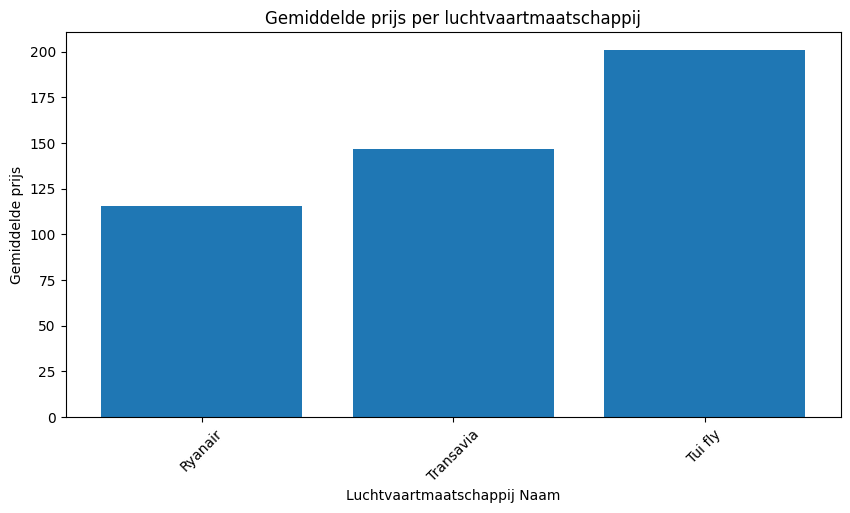

In [9]:
plt.figure(figsize=(10, 5))
plt.bar(airline_prices_sorted['airline_iata_code'], airline_prices_sorted['price'])
plt.xlabel('Luchtvaartmaatschappij Naam')
plt.ylabel('Gemiddelde prijs')
plt.title('Gemiddelde prijs per luchtvaartmaatschappij')
plt.xticks(rotation=45)
plt.show()

# 2. Hoe vaak vliegt elke vliegtuigmaatschappij per week naar elk van de bestemmingen?

#### Data Opschonen, Dubbele Rijen Verwijderen en Weeknummers Toevoegen aan Dataset

In [10]:
data = df.copy(deep=True)
data['departure_date'] = pd.to_datetime(data['departure_date'])
data = data.drop_duplicates(subset=['flight_id', 'departure_date'])
data['week_number'] = data['departure_date'].dt.isocalendar().week
unique_airlines = data['airline_iata_code'].unique()

#### Aantal vluchten per week voor elke bestemming per airline

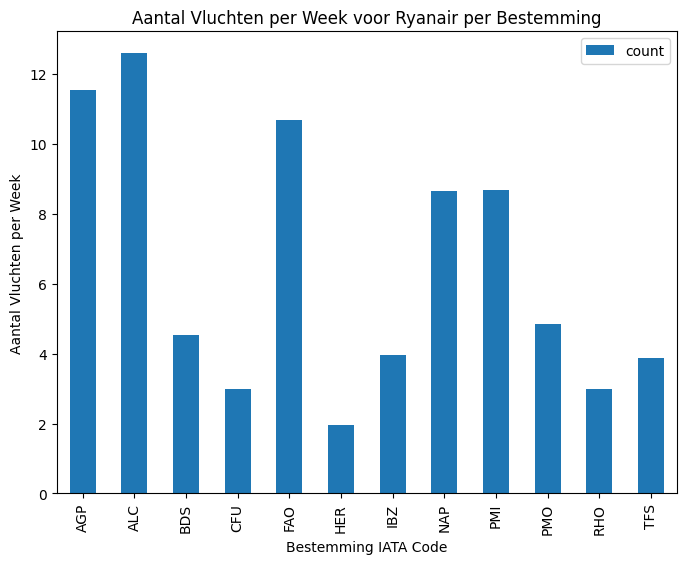

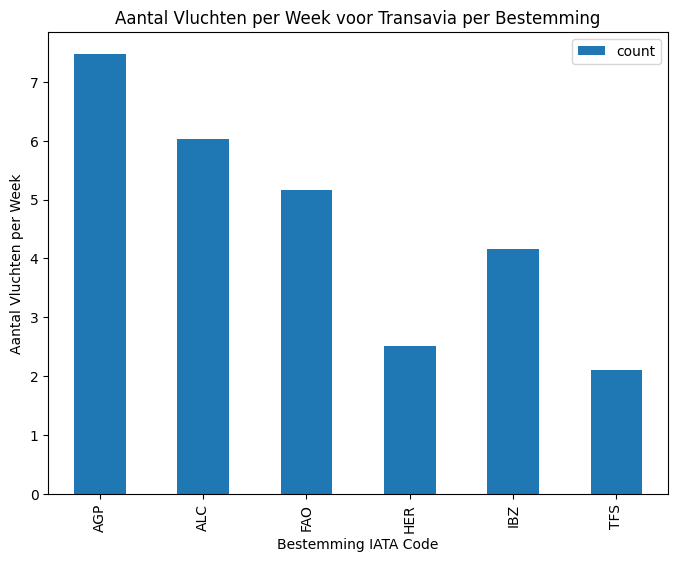

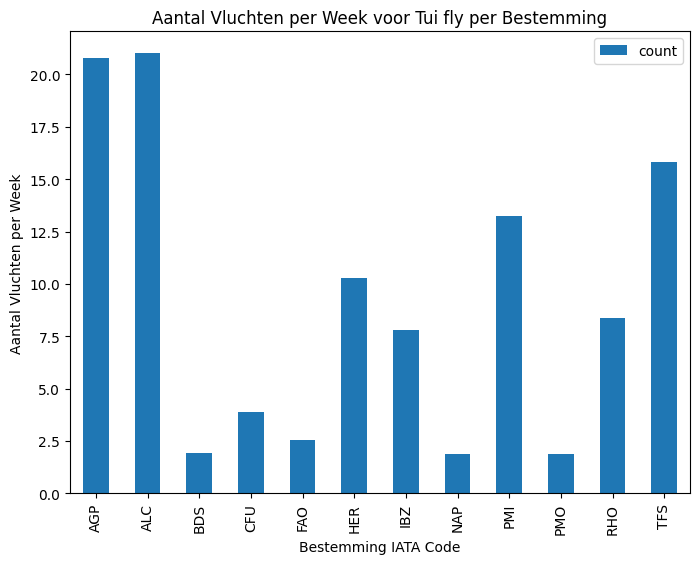

In [11]:
def plot_airline_chart(airline_data, airline_code):
    grouped_data = airline_data.groupby(['arrival_airport_iata_code', 'week_number']).size().reset_index(name='count')
    weekly_data = grouped_data.groupby('arrival_airport_iata_code')['count'].mean().reset_index()
    
    ax = weekly_data.plot(x='arrival_airport_iata_code', y='count', kind='bar', figsize=(8, 6))
    plt.ylabel('Aantal Vluchten per Week')
    plt.xlabel('Bestemming IATA Code')
    plt.title(f'Aantal Vluchten per Week voor {IATA_TO_NAME[airline_code]} per Bestemming')
    plt.show()

for airline_code in unique_airlines:
    airline_data = data[data['airline_iata_code'] == airline_code]
    plot_airline_chart(airline_data, airline_code)

# 3. Welke vlucht biedt de goedkoopste vlucht aan?
#### Dataframe filteren door enkel rijen over te laten waar de tijd tussen departure_date en scrape_date niet te groot en niet te klein is

In [12]:
def mask_func(x):
    dif = (dt.strptime(x["departure_date"], "%Y-%m-%d") - dt.strptime(x["scrape_date"], "%Y-%m-%d")).days
    return (dif > 14 and dif < 31)

data = df.copy(deep=True)
correct_data = data[data.apply(mask_func, axis=1)]

#### Minimumprijs berekenen, en rijen tonen die dezelfde prijs hebben

In [13]:
correct_data[correct_data["price"] == correct_data["price"].min()]

,flight_id,flightnumber,departure_date,arrival_date,departure_time,arrival_time,duration,number_of_stops,airline_iata_code,departure_airport_iata_code,arrival_airport_iata_code,scrape_date,available_seats,price
55659,FR_CRL_NAP_2023-05-09_FR1302,FR1302,2023-05-09,2023-05-09,19:20,21:35,02:15,0,FR,CRL,NAP,2023-04-10,1,19.99
55667,FR_CRL_PMI_2023-05-09_FR7831,FR7831,2023-05-09,2023-05-09,06:35,08:45,02:10,0,FR,CRL,PMI,2023-04-10,4,19.99
55670,FR_CRL_NAP_2023-05-10_FR1302,FR1302,2023-05-10,2023-05-10,16:35,18:50,02:15,0,FR,CRL,NAP,2023-04-10,2,19.99
80967,FR_CRL_NAP_2023-05-09_FR1302,FR1302,2023-05-09,2023-05-09,19:20,21:35,02:15,0,FR,CRL,NAP,2023-04-09,3,19.99
80975,FR_CRL_PMI_2023-05-09_FR7831,FR7831,2023-05-09,2023-05-09,06:35,08:45,02:10,0,FR,CRL,PMI,2023-04-09,-1,19.99
86156,FR_CRL_NAP_2023-05-23_FR1302,FR1302,2023-05-23,2023-05-23,19:20,21:35,02:15,0,FR,CRL,NAP,2023-04-23,-1,19.99
120201,FR_CRL_NAP_2023-05-23_FR1302,FR1302,2023-05-23,2023-05-23,19:20,21:35,02:15,0,FR,CRL,NAP,2023-04-24,4,19.99


#### Conclusie:
- Elke vlucht met de minimumprijs wordt uitgevoerd door Ryanair.
- De vluchten vertrekken enkel van charleroi, en vliegen enkel naar napoli en palma de mallorca

# 4. Is er een correlatie met de vakantiebestemmingen: zijn bepaalde bestemmingen significant duurder dan andere bestemmingen?¶

In [14]:
data = df.copy(deep=True)

# add average of flight cost over different points in time
d = {}
for x in data["flight_id"].unique():
    if x not in d.keys():
        d[x] = data[data["flight_id"] == x]["price"].mean()
        
df2 = pd.DataFrame([d.keys(), d.values()]).transpose()
df2.columns = ["flight_id", "avg_price"]
df2

,flight_id,avg_price
0,FR_CRL_AGP_2023-05-10_FR1916,109.509091
1,FR_CRL_RHO_2023-05-10_FR8577,123.560606
2,FR_CRL_NAP_2023-05-10_FR1302,63.024848
3,FR_CRL_FAO_2023-05-10_FR6312,89.006061
4,FR_CRL_ALC_2023-05-10_FR3534,118.503333
...,...,...
5586,HV_BRU_HER_2023-07-29_HV9211,222.0
5587,HV_BRU_HER_2023-08-15_HV9209,241.0
5588,HV_BRU_HER_2023-08-22_HV9209,161.0
5589,HV_BRU_FAO_2023-08-13_HV9011,122.0


In [15]:
df2["to"] = df2.flight_id.map(lambda x: x.split('_')[2])
df2

,flight_id,avg_price,to
0,FR_CRL_AGP_2023-05-10_FR1916,109.509091,AGP
1,FR_CRL_RHO_2023-05-10_FR8577,123.560606,RHO
2,FR_CRL_NAP_2023-05-10_FR1302,63.024848,NAP
3,FR_CRL_FAO_2023-05-10_FR6312,89.006061,FAO
4,FR_CRL_ALC_2023-05-10_FR3534,118.503333,ALC
...,...,...,...
5586,HV_BRU_HER_2023-07-29_HV9211,222.0,HER
5587,HV_BRU_HER_2023-08-15_HV9209,241.0,HER
5588,HV_BRU_HER_2023-08-22_HV9209,161.0,HER
5589,HV_BRU_FAO_2023-08-13_HV9011,122.0,FAO


In [16]:
groups = [df2[df2["to"] == d]["avg_price"] for d in df2["to"].unique()]

f, p = f_oneway(*groups)
print(f"f: {f}, p: {p}")

f: 105.76792621309578, p: 7.760484171296057e-220


<Axes: xlabel='to', ylabel='avg_price'>

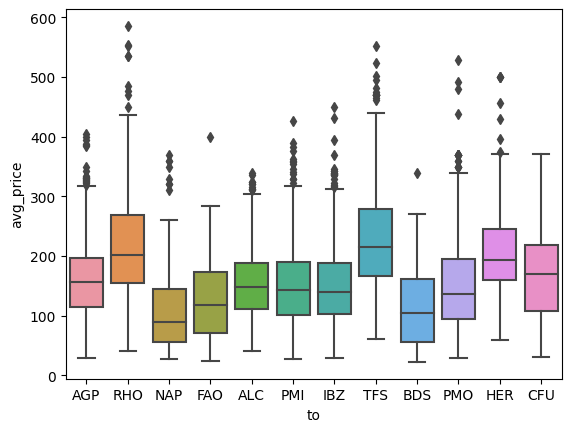

In [17]:
mean_prices = df2.groupby('to')["avg_price"].mean().sort_values(ascending=False)
mean_prices_df = pd.DataFrame({'to': mean_prices.index, 'mean_price': mean_prices.values})

sns.boxplot(x='to', y='avg_price', data=df2)

<Axes: xlabel='to', ylabel='mean_price'>

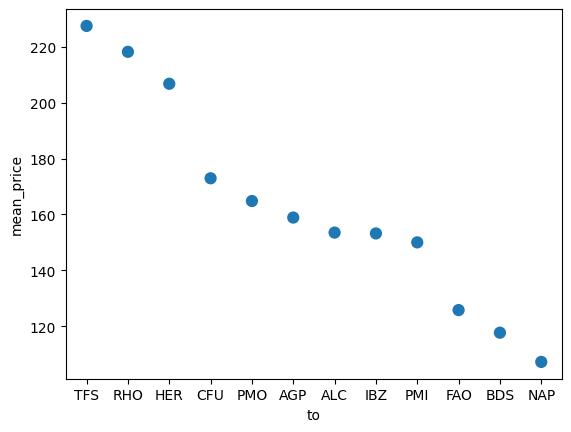

In [18]:
sns.pointplot(x='to', y='mean_price', data=mean_prices_df, join=False, errorbar='sd')

# 5. Hoeveel plaatsen vrij 5 dagen voor vertrek?

In [22]:
data = df.copy(deep=True)
data = data[data['available_seats'] != -1]
data['departure_date'] = pd.to_datetime(data['departure_date'])
data['scrape_date'] = pd.to_datetime(data['scrape_date'])

# Filter rijen waar het verschil tussen vertrekdatum en schraapdatum 5 dagen is
five_days_before_departure = data[data['departure_date'] - data['scrape_date'] == pd.Timedelta(days=5)]

# Groepeer gegevens op airline_iata_code en available_seats, en tel het aantal keren
seat_counts = five_days_before_departure.groupby(['airline_iata_code', 'available_seats']).size().reset_index(name='occurrences')

#### Bereken het gemiddelde aantal beschikbare stoelen voor de gefilterde rijen

In [20]:
average_seats = five_days_before_departure['available_seats'].mean()
print(f"Gemiddeld beschikbare stoelen 5 dagen voor vertrek: {average_seats:.2f}")

Gemiddeld beschikbare stoelen 5 dagen voor vertrek: 3.27


#### Frequentieverdeling van Beschikbare Zitplaatsen per Luchtvaartmaatschappij 5 dagen voor vertrek

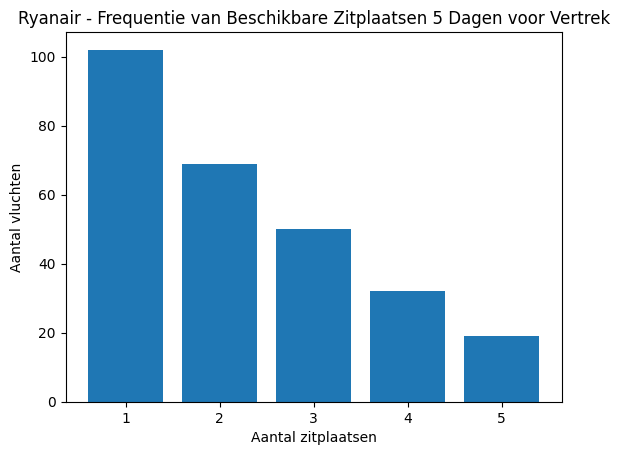

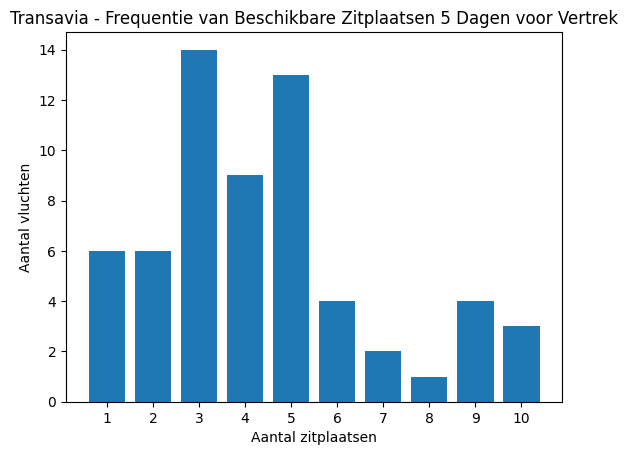

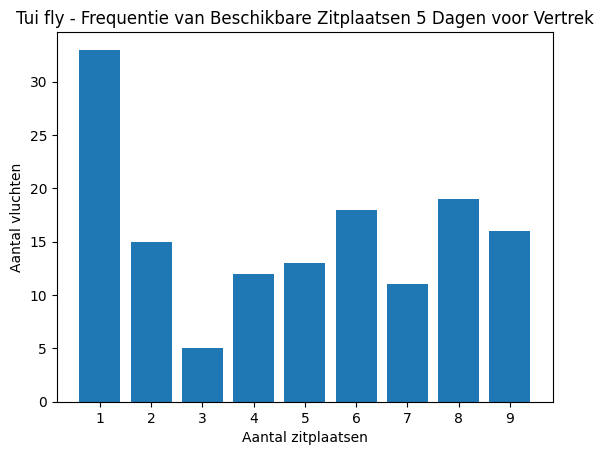

In [24]:
for airline_code in seat_counts['airline_iata_code'].unique():
    airline_data = seat_counts[seat_counts['airline_iata_code'] == airline_code]
    plt.bar(airline_data['available_seats'], airline_data['occurrences'])
    plt.xticks(airline_data['available_seats'])  #
    plt.xlabel('Aantal zitplaatsen')
    plt.ylabel('Aantal vluchten')
    plt.title(f"{IATA_TO_NAME[airline_code]} - Frequentie van Beschikbare Zitplaatsen 5 Dagen voor Vertrek")
    plt.show()